In [1]:
import sys
import os
directory = os.path.abspath(os.path.join('..'))
sys.path.append(directory)
import numpy as np
from matplotlib import pyplot as plt
from scripts.model_params import *
from scripts.cell_model import *
from scripts.batch_culture_simulation import *
import os
from pymoo.algorithms.soo.nonconvex.ga import GA
from pymoo.core.problem import ElementwiseProblem
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
import numpy as np
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.termination import get_termination

Defining and importing base parameters

In [2]:
# defining parameters
sS0 = 0.5; cultvol = 1.25 #quality of the nutrients and volume of the culture
vX = 726; kX = 1e3 # X export parameters
tmax = 20000; runintmax = 1e6 #simulation time parameters

N0  = 1e6
xS0 = 4.180555555555556e+22; # amount of glucose in media = 10g/L in 1.25L working vol in 3L vessel
M0 = 1e8 

Defining the system topology parameters

In [3]:
#choosing the product transport method. 1 indicates this method is included
lin_trans      = 1
Tp_trans       = 0
T_trans        = 0
diff_trans     = 0

#mutaually exclusive; only one of these can be 1, rest must be 0
eprodtox       = 1
elongationtox  = 0

topology = [lin_trans, Tp_trans, T_trans, diff_trans, eprodtox, elongationtox]

creating the host and engineered parameter arrays

In [4]:
base_params = [xS0, 0, runintmax, tmax, N0, topology]

hPR0, xPR0 = model_params(sS0, vX, kX, cultvol, leaky_control=False)
hPR = np.array(hPR0)
xPR = np.array(xPR0)
# 0     1       2       3       4         5        6        7           8
#[w0,   wE,     wEp,    wTF,    wpTox,    wTp,     k_Ep,    Km_Ep,      k_Tp,
#   9      10             11                 12
# # Km_Tp, a_energy_pTox, a_elongation_pTox, K_E, 
#   13      14      15       16       17   18
# # K_pTox, kdiffP, VolCell, VolCult, ksf, ksr]

Setting specific circuit parameters

In [5]:
wT = 20; wE = 20; wEp = 20; wTF = 20; wpTox = 20;
K_E = 0.3; K_pTox = 1.0

xPR[[1, 2, 3, 4, 5, 13, 14]] = [wT, wE, wEp, wTF, wpTox, K_E, K_pTox]

param_indices = [1, 2, 3, 4, 5, 13, 14]             # e.g., wEp at index 2 (old behaviour)
# param_indices = [2, 3, 12]    # Example: optimize wEp, wTF, K_E
lower_bounds  = [0, 0, 0, 0, 0, 0, 0]             # lower bounds for each parameter
upper_bounds  = [200, 200, 200, 200, 200, 200, 200]           # upper bounds

n_params = len(param_indices)

Writing a wrapper to take wEp and return the productivity and yield

In [6]:
def calculate_prod_yield(x_vector):
    xPR_local = xPR.copy()
    for idx, value in zip(param_indices, x_vector):
        xPR_local[idx] = value

    _, __, vP, pY = batch_cult_sim(base_params, hPR, xPR_local)

    return -np.log(vP), -np.log(pY)

Setting up the optimisation problems

In [7]:
class SingleObjective(ElementwiseProblem):
    def __init__(self, obj_id):
        super().__init__(n_var=n_params,
                         n_obj=1,
                         xl=lower_bounds,
                         xu=upper_bounds)
        self.obj_id = obj_id

    def _evaluate(self, x, out):
        obj_vec = calculate_prod_yield(x)
        out["F"] = obj_vec[self.obj_id]


class MultiObjectiveScaled(ElementwiseProblem):
    def __init__(self, scale):
        super().__init__(n_var=n_params,
                         n_obj=2,
                         xl=lower_bounds,
                         xu=upper_bounds)
        self.scale = scale

    def _evaluate(self, x, out):
        vP_log, pY_log = calculate_prod_yield(x)
        out["F"] = np.array([vP_log, pY_log]) / self.scale

Running the optimisation to find optimal vP

In [8]:
single_termination = get_termination("n_gen", 50)
res_vP = minimize(
    SingleObjective(obj_id=0),
    GA(pop_size=30),
    termination=single_termination,
    seed=1,
    verbose=True
)
max_vP_log = res_vP.F[0]
print("Max vP:", np.exp(-max_vP_log))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       30 | -4.472503E+01 | -4.568942E+01
     2 |       60 | -4.543887E+01 | -4.568942E+01
     3 |       90 | -4.561824E+01 | -4.568997E+01
     4 |      120 | -4.567641E+01 | -4.572610E+01
     5 |      150 | -4.570469E+01 | -4.580556E+01
     6 |      180 | -4.573554E+01 | -4.580556E+01
     7 |      210 | -4.577563E+01 | -4.583849E+01
     8 |      240 | -4.580502E+01 | -4.584342E+01
     9 |      270 | -4.581871E+01 | -4.584520E+01
    10 |      300 | -4.583286E+01 | -4.585239E+01
    11 |      330 | -4.584406E+01 | -4.586075E+01
    12 |      360 | -4.584982E+01 | -4.586075E+01
    13 |      390 | -4.585709E+01 | -4.587621E+01
    14 |      420 | -4.586203E+01 | -4.587621E+01
    15 |      450 | -4.586740E+01 | -4.588276E+01
    16 |      480 | -4.587397E+01 | -4.588276E+01
    17 |      510 | -4.588022E+01 | -4.589162E+01
    18 |      540 | -4.588496E+01 | -4.590215E+01
    19 |      570 | -4.589050E+01 | -4.590333E+01


Running the optimisation to find optimisal pY

In [9]:
res_pY = minimize(
    SingleObjective(obj_id=1),
    GA(pop_size=30),
    termination=single_termination,
    seed=1,
    verbose=True
)
max_pY_log = res_pY.F[0]
print("Max pY:", np.exp(-max_pY_log))

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       30 |  1.1320931847 |  0.0334139198
     2 |       60 |  0.4157959752 |  0.0239016546
     3 |       90 |  0.0927144416 |  0.0034288247
     4 |      120 |  0.0266033627 |  0.0034249398
     5 |      150 |  0.0168132218 |  0.0034249398
     6 |      180 |  0.0103389637 |  0.0027253823
     7 |      210 |  0.0036236975 |  0.0027253823
     8 |      240 |  0.0030086893 |  0.0022361454
     9 |      270 |  0.0026941415 |  0.0022361454
    10 |      300 |  0.0026770627 |  0.0022361454
    11 |      330 |  0.0025804903 |  0.0021173198
    12 |      360 |  0.0025063620 |  0.0021173198
    13 |      390 |  0.0024432546 |  0.0021173198
    14 |      420 |  0.0023643499 |  0.0021173198
    15 |      450 |  0.0022647509 |  0.0021027645
    16 |      480 |  0.0021761824 |  0.0020987390
    17 |      510 |  0.0021206167 |  0.0019715750
    18 |      540 |  0.0021056791 |  0.0019715750
    19 |      570 |  0.0020937188 |  0.0019715750


Running the multiobjective optimisation

In [10]:
scale = np.array([abs(max_vP_log), abs(max_pY_log)])
termination = get_termination("n_gen", 80)
res = minimize(
    MultiObjectiveScaled(scale),
    NSGA2(pop_size=60),
    termination,
    seed=1,
    verbose=True
)

n_gen  |  n_eval  | n_nds  |      eps      |   indicator  
     1 |       60 |      5 |             - |             -
     2 |      120 |     11 |  0.0511920115 |         ideal
     3 |      180 |     20 |  0.0070505963 |         ideal
     4 |      240 |     31 |  0.0088531023 |             f
     5 |      300 |     35 |  0.0039785708 |         ideal
     6 |      360 |     52 |  0.0155120533 |         ideal
     7 |      420 |     49 |  0.0025867846 |         ideal
     8 |      480 |     56 |  0.0161042253 |         ideal
     9 |      540 |     49 |  0.0054214176 |             f
    10 |      600 |     57 |  0.0034588695 |         nadir
    11 |      660 |     60 |  0.0554631528 |         nadir
    12 |      720 |     60 |  0.0404376082 |         nadir
    13 |      780 |     60 |  0.0040760783 |             f
    14 |      840 |     60 |  0.0583535775 |         nadir
    15 |      900 |     60 |  0.0532542603 |         nadir
    16 |      960 |     60 |  0.0030929961 |            

Extracting the pareto front

In [11]:
pareto_X = res.X                          # parameter sets
pareto_scaled = res.F                     # scaled objectives
pareto_unscaled = pareto_scaled * scale   # real objectives

vP_vals = np.exp(-pareto_unscaled[:, 0])
pY_vals = np.exp(-pareto_unscaled[:, 1])

print("Pareto points:", len(vP_vals))

Pareto points: 60


Now plotting the pareto front

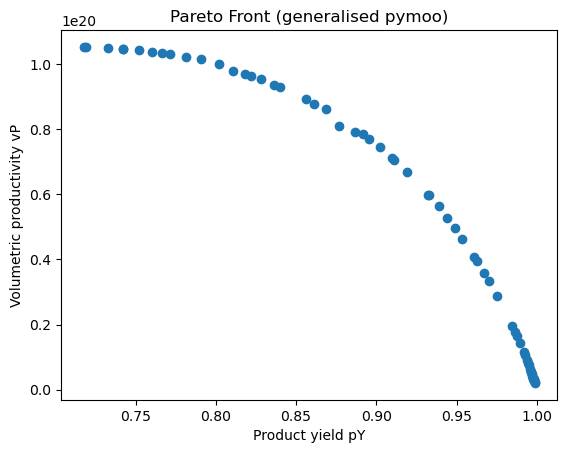

In [12]:
plt.scatter(pY_vals, vP_vals)
plt.xlabel("Product yield pY")
plt.ylabel("Volumetric productivity vP")
plt.title("Pareto Front (generalised pymoo)")
plt.show()